# AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

This project trains an image classifier to recognize different species of flowers. Imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. This project will train this classifier, then export it for use in an application. This project uses [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) from Oxford of 102 flower categories. Below are a few examples. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load the image dataset and create a pipeline.
* Build and Train an image classifier on this dataset.
* Use the trained model to perform inference on flower images.

After completing this notebook, this project creates an application that can be trained on any set of labeled images. Here the network will be learning about flowers and end up as a command line application. This can be implemented for other applications-- imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it.

## Import Resources

In [144]:
# Make all necessary imports.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import time
from PIL import Image

# Tensorflow imports
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

# Print the version of TensorFlow and tf.keras, and print whether or not computer is running on GPU
print('Using:')
print('\t\u2022 TensorFlow version:', tf.__version__)
print('\t\u2022 tf.keras version:', tf.keras.__version__)
print('\t\u2022 Running on GPU' if tf.test.is_gpu_available() else '\t\u2022 GPU device not found. Running on CPU')

Using:
	• TensorFlow version: 2.2.0-rc3
	• tf.keras version: 2.3.0-tf
	• Running on GPU


## Load the Dataset

Use `tensorflow_datasets` to load the [Oxford Flowers 102 dataset](https://www.tensorflow.org/datasets/catalog/oxford_flowers102). This dataset has 3 splits: `'train'`, `'test'`, and `'validation'`.  Ensure that the training data is normalized and resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet, but the data still needs to be normalized and the images need to be resized to the appropriate size.

In [3]:
# Load the dataset with TensorFlow Datasets.
dataset, dataset_info = tfds.load('oxford_flowers102', as_supervised = True, with_info = True)

# Check that dataset is a dictionary
print('dataset has type:', type(dataset))

# Print the keys of the dataset dictionary
print('\nThe keys of dataset are:', list(dataset.keys()))

# Create a training set, a validation set and a test set.
training_set, test_set, validation_set = dataset['train'], dataset['test'], dataset['validation']

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Shuffling and writing examples to /root/tensorflow_datasets/oxford_flowers102/2.0.0.incompleteQWVEA4/oxford_flowers102-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/oxford_flowers102/2.0.0.incompleteQWVEA4/oxford_flowers102-test.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/oxford_flowers102/2.0.0.incompleteQWVEA4/oxford_flowers102-validation.tfrecord



Dataset oxford_flowers102 downloaded and prepared to /root/tensorflow_datasets/oxford_flowers102/2.0.0. Subsequent calls will reuse this data.
dataset has type: <class 'dict'>

The keys of dataset are: ['test', 'train', 'validation']


#### Print the dataset info

In [4]:
dataset_info

tfds.core.DatasetInfo(
    name='oxford_flowers102',
    version=2.0.0,
    description='
The Oxford Flowers 102 dataset is a consistent of 102 flower categories commonly occurring
in the United Kingdom. Each class consists of between 40 and 258 images. The images have
large scale, pose and light variations. In addition, there are categories that have large
variations within the category and several very similar categories.

The dataset is divided into a training set, a validation set and a test set.
The training set and validation set each consist of 10 images per class (totalling 1020 images each).
The test set consists of the remaining 6149 images (minimum 20 per class).
',
    homepage='https://www.robots.ox.ac.uk/~vgg/data/flowers/102/',
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=102),
    }),
    total_num_examples

## Explore the Dataset

#### Find the number of images in each set (test, training, & validation), the number of classes in our dataset, and the shape of the images (each of images have different sizes)

In [5]:
# Get the number of examples in each set from the dataset info.
num_training_examples  = dataset_info.splits['train'].num_examples
num_test_examples = dataset_info.splits['test'].num_examples
num_validation_examples = dataset_info.splits['validation'].num_examples

print('\nThere are {:,} images in the test set'.format(num_test_examples))
print('There are {:,} images in the training set'.format(num_training_examples))
print('There are {:,} images in the validation set'.format(num_validation_examples))

#  Get the number of classes in the dataset from the dataset info & Print the shape of the images in the dataset
shape_images = dataset_info.features['image'].shape
num_classes = dataset_info.features['label'].num_classes
print('There are {:,} classes in our dataset'.format(num_classes))
print('The images in our dataset have shape:', shape_images)



There are 6,149 images in the test set
There are 1,020 images in the training set
There are 1,020 images in the validation set
There are 102 classes in our dataset
The images in our dataset have shape: (None, None, 3)


#### Print the shape and corresponding label of 3 images in the training set

In [6]:
# Print the shape and corresponding label of 3 images in the training set.
for image, label in training_set.take(3):
    label = label.numpy()
    print('The images in the training set have:\n\u2022 label:', label, '\n\u2022 shape:', image.shape)
    image = image.numpy().squeeze()

The images in the training set have:
• label: 72 
• shape: (500, 667, 3)
The images in the training set have:
• label: 84 
• shape: (500, 666, 3)
The images in the training set have:
• label: 70 
• shape: (670, 500, 3)


#### Plot 1 image from the training set

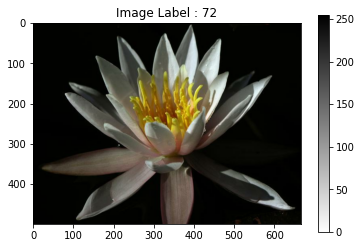

In [31]:
# Plot 1 image from the training set. Set the title 
# of the plot to the corresponding image label. 
for image, label in training_set.take(1):
    image = image.numpy().squeeze()
    label = label.numpy()
    
# Plot the image
plt.imshow(image, cmap = plt.cm.binary)
plt.title(f'Image Label : {label}')
plt.colorbar()
plt.show()

### Label Mapping

Load in a mapping from label to category name. This is found in the file `label_map.json`. It's a JSON object which will be read in with the [`json` module](https://docs.python.org/3.7/library/json.html). This will give a dictionary mapping the integer coded labels to the actual names of the flowers.

#### Load `label_map.json`

In [0]:
# Load label_map.json
with open('label_map.json', 'r') as f:
    class_names = json.load(f)

#### Fix that the class names are off by one in the JSON file

In [30]:
# Fix that the class names are off by one:
new_class_names = {}
for key in class_names:
    new_class_names[int(key)-1]=class_names[key]
# Print the fixed class names
new_class_names

{0: 'pink primrose',
 1: 'hard-leaved pocket orchid',
 2: 'canterbury bells',
 3: 'sweet pea',
 4: 'english marigold',
 5: 'tiger lily',
 6: 'moon orchid',
 7: 'bird of paradise',
 8: 'monkshood',
 9: 'globe thistle',
 10: 'snapdragon',
 11: "colt's foot",
 12: 'king protea',
 13: 'spear thistle',
 14: 'yellow iris',
 15: 'globe-flower',
 16: 'purple coneflower',
 17: 'peruvian lily',
 18: 'balloon flower',
 19: 'giant white arum lily',
 20: 'fire lily',
 21: 'pincushion flower',
 22: 'fritillary',
 23: 'red ginger',
 24: 'grape hyacinth',
 25: 'corn poppy',
 26: 'prince of wales feathers',
 27: 'stemless gentian',
 28: 'artichoke',
 29: 'sweet william',
 30: 'carnation',
 31: 'garden phlox',
 32: 'love in the mist',
 33: 'mexican aster',
 34: 'alpine sea holly',
 35: 'ruby-lipped cattleya',
 36: 'cape flower',
 37: 'great masterwort',
 38: 'siam tulip',
 39: 'lenten rose',
 40: 'barbeton daisy',
 41: 'daffodil',
 42: 'sword lily',
 43: 'poinsettia',
 44: 'bolero deep blue',
 45: 'wall

#### Plot 1 image from the training set

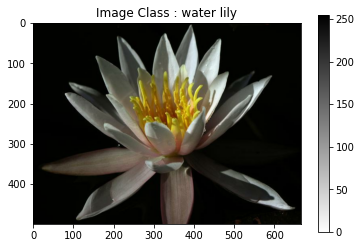

In [32]:
# Plot 1 image from the training set. Set the title 
# of the plot to the corresponding class name. 
for image, label in training_set.take(1):
    image = image.numpy().squeeze()
    label = label.numpy()
    
# Plot the image
plt.imshow(image, cmap = plt.cm.binary)
img_class = new_class_names[label]
plt.title(f'Image Class : {img_class}')
plt.colorbar()
plt.show()


## Create Pipeline

In [106]:
# Create a pipeline for each set.
image_size = 224

# Create the normalize function that makes the image shape = (224,224,3) and divides the values by 225
def normalize(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, (224, 224))
    image /= 255
    return image, label

# Set the batch size equal to 32
batch_size = 32

# Create the training, testing, and validation batches
# Normalize each batch & set the batch size 
training_batches = training_set.cache().shuffle(num_training_examples//4).map(normalize).batch(batch_size).prefetch(1)
testing_batches = test_set.cache().map(normalize).batch(batch_size).prefetch(1)
validation_batches = validation_set.cache().map(normalize).batch(batch_size).prefetch(1)

# Print the data type of the images, the shape of the images, the total number of image labels, and the image labels in the training batch 
for image_batch, label_batch in training_batches.take(1):
    print('The images in each batch have:')
    print('\u2022 dtype:', image_batch.dtype) 
    print('\u2022 shape:', image_batch.shape)
  
    print('\nThere are a total of {} image labels in this batch:'.format(label_batch.numpy().size))
    print(label_batch.numpy())

The images in each batch have:
• dtype: <dtype: 'float32'>
• shape: (32, 224, 224, 3)

There are a total of 32 image labels in this batch:
[  2  15  18  46  50  95  50  11 101  93  42  30   2  87  60  72  53   2
  98  47  94  46  32  16  99  20  17  55   0  63  41  51]


# Build and Train the Classifier

Now that the data is ready, it's time to build and train the classifier. Use the MobileNet pre-trained model from TensorFlow Hub to get the image features. Build and train a new feed-forward classifier using those features.


Steps:

* Load the MobileNet pre-trained network from TensorFlow Hub.
* Define a new, untrained feed-forward network as a classifier.
* Train the classifier.
* Plot the loss and accuracy values achieved during training the the training and validation set.
* Save your trained model as a Keras model. 

When training, update only the weights of the feed-forward network. The goal is to get the validation accuracy above 70%.

#### Load the MobileNet pre-trained network from TensorFlow Hub

In [0]:
# Build and train your network.

#Load the MobileNet pre-trained network from TensorFlow Hub
'''
Download the pre-trained MobileNet model without the final classification layer from TensorFlow Hub 
using the hub.KerasLayer(URL) function. This function downloads the desired model form the given 
TensorFlow Hub URL and wraps it in a Keras layer so that we can integrate it in a tf.keras Sequential model later. 
Since this will be the first layer of our Sequential model, we need to specify the input_shape parameter. 
The shape of our input tensor must match the size of the images MobileNet was trained on, namely (224,224,3)
'''
IMAGE_SHAPE = (224, 224)
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
feature_extractor = hub.KerasLayer(URL, input_shape=(image_size, image_size,3))

# Freeze the weights and biases in pre-trained model
feature_extractor.trainable = False

#### Define a new, untrained feed-forward network as a classifier

In [127]:
#Define a new, untrained feed-forward network as a classifier
# Create a tf.keras Sequential model with our feature_extractor and a new classification layer. 
# Since our dataset has 102 we create an output layer with 102 units
model = tf.keras.Sequential([
        feature_extractor,
        tf.keras.layers.Dense(256, activation = 'relu'),
        tf.keras.layers.Dense(128, activation = 'relu'),
        tf.keras.layers.Dense(64, activation = 'relu'),
        tf.keras.layers.Dense(102, activation = 'softmax')
])

# Print the model summary
model.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_10 (KerasLayer)  (None, 1280)              2257984   
_________________________________________________________________
dense_46 (Dense)             (None, 256)               327936    
_________________________________________________________________
dense_47 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_48 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_49 (Dense)             (None, 102)               6630      
Total params: 2,633,702
Trainable params: 375,718
Non-trainable params: 2,257,984
_________________________________________________________________


#### Train the classifier

In [128]:
# Print if there is GPU available
print('Is there a GPU Available:', tf.test.is_gpu_available())

#Train the classifier
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])

Is there a GPU Available: True


#### Define a new, untrained feed-forward network as a classifier, print the model summary, train the model, and fit the model to `training_batches` with 30 epochs and validation data as `validation_batches`

In [140]:
#Define a new, untrained feed-forward network as a classifier
# Create a tf.keras Sequential model with our feature_extractor and a new classification layer. 
# Since the dataset has 102 classes, we create an output layer with 102 units
# Using Dropout gives best accuracy
model = tf.keras.Sequential([
        feature_extractor,
        tf.keras.layers.Dense(256, activation = 'relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(128, activation = 'relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(64, activation = 'relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(102, activation = 'softmax')
])

# Print the model summary
model.summary()

# Train the model
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])

# Use 30 Epochs as it gives the best accuracy
EPOCHS = 30

# Fit the model
history = model.fit(training_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_10 (KerasLayer)  (None, 1280)              2257984   
_________________________________________________________________
dense_54 (Dense)             (None, 256)               327936    
_________________________________________________________________
dropout_9 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_55 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_10 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_56 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_11 (Dropout)         (None, 64)              

#### Plot the loss and accuracy values achieved during training for the training and validation set.

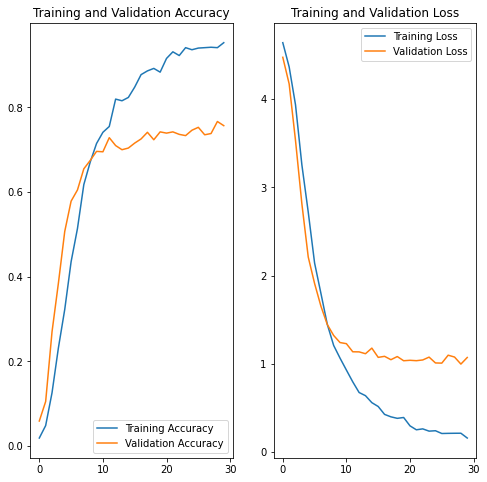

In [141]:
# Plot the loss and accuracy values achieved during training for the training and validation set.
training_accuracy = history.history['acc']
validation_accuracy = history.history['val_acc']

training_loss = history.history['loss']
validation_loss = history.history['val_loss']

epochs_range=range(EPOCHS)

# Plot the Training vs Validation Accuracy
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, training_accuracy, label='Training Accuracy')
plt.plot(epochs_range, validation_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Plot the Training vs Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, training_loss, label='Training Loss')
plt.plot(epochs_range, validation_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Testing your Network

Test the trained network on test data, images the network has never seen either in training or validation. This gives a good estimate for the model's performance on completely new images. The goal, if the model has been trained well, is to reach around 70% accuracy on the test set.

#### Print the loss and accuracy values achieved on the entire test set.

In [142]:
# Print the loss and accuracy values achieved on the entire test set.
loss, accuracy = model.evaluate(testing_batches)

print('\nLoss on the TEST Set: {:,.3f}'.format(loss))
print('Accuracy on the TEST Set: {:.3%}'.format(accuracy))

193/193 [==============================] - 18s 92ms/step - loss: 1.2999 - acc: 0.7126

Loss on the TEST Set: 1.300
Accuracy on the TEST Set: 71.264%


## Save the Model

Now that the network is trained, save the model so one can load it later for making inference. In the cell below save the model as a Keras model (save it as an HDF5 file).

In [0]:
# Save the trained model as a Keras model.
t = time.time()

saved_keras_model_filepath = './{}.h5'.format(int(t))

model.save(saved_keras_model_filepath)

## Load the Keras Model

Load the Keras model saved above.

In [155]:
# Load the Keras model
reloaded_keras_model = tf.keras.models.load_model(saved_keras_model_filepath, custom_objects={'KerasLayer':hub.KerasLayer})

# Print the summary of the loaded Keras model
reloaded_keras_model.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_10 (KerasLayer)  (None, 1280)              2257984   
_________________________________________________________________
dense_54 (Dense)             (None, 256)               327936    
_________________________________________________________________
dropout_9 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_55 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_10 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_56 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_11 (Dropout)         (None, 64)              

# Inference for Classification

Now create a function that uses your trained network for inference. Create a function called `predict` that takes an image, a model, and then returns the top $K$ most likely class labels along with the probabilities. The function call looks like: 

```python
probs, classes = predict(image_path, model, top_k)
```

If `top_k=5` the output of the `predict` function is something like this:

```python
probs, classes = predict(image_path, model, 5)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

The `predict` function uses `PIL` to load the image from the given `image_path`. Use the [Image.open](https://pillow.readthedocs.io/en/latest/reference/Image.html#PIL.Image.open) function to load the images. The `Image.open()` function returns an `Image` object. Convert this `Image` object to a NumPy array by using the `np.asarray()` function.

The `predict` function also handles pre-processing the input image such that it can be used by the model. Thus, create another function called `process_image` that performs the pre-processing. Then call the `process_image` function from the `predict` function. 

### Image Pre-processing

The `process_image` function takes in an image (in the form of a NumPy array) and returns an image in the form of a NumPy array with shape `(224, 224, 3)`.

First, convert the image into a TensorFlow Tensor and then resize it to the appropriate size using `tf.image.resize`.

Second, the pixel values of the input images are typically encoded as integers in the range 0-255, but the model expects the pixel values to be floats in the range 0-1. Therefore, normalize the pixel values. 

Finally, convert the image back to a NumPy array using the `.numpy()` method.

#### Create the process_image function

In [14]:
# Create the process_image function
def process_image(image):
    '''
    The process_image function should take in an image (in the form of a NumPy array) and return an image in the form of a NumPy array with shape (224, 224, 3).
    '''
    
    # Convert the image into a TensorFlow Tensor
    image = tf.convert_to_tensor(image, dtype=tf.float32)
    
    # Resize it to the appropriate size using tf.image.resize
    image = tf.image.resize(image, (224,224))
    
    # Normalize the pixel values
    image /= 255
    
    # Convert the image back to a NumPy array using the .numpy() method
    image = image.numpy()
    return image


Check the `process_image` function by using 4 images in the `./test_images/` folder:

* cautleya_spicata.jpg
* hard-leaved_pocket_orchid.jpg
* orange_dahlia.jpg
* wild_pansy.jpg

The code below loads one of the above images using `PIL` and plots the original image alongside the image produced by the `process_image` function. If the `process_image` function works, the plotted image should be the correct size.

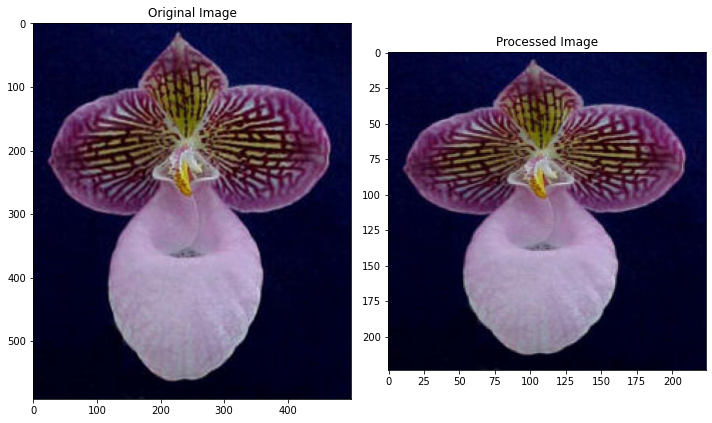

In [173]:
from PIL import Image

image_path = './test_images/hard-leaved_pocket_orchid.jpg'
im = Image.open(image_path)
test_image = np.asarray(im)

processed_test_image = process_image(test_image)

fig, (ax1, ax2) = plt.subplots(figsize=(10,10), ncols=2)
ax1.imshow(test_image)
ax1.set_title('Original Image')
ax2.imshow(processed_test_image)
ax2.set_title('Processed Image')
plt.tight_layout()
plt.show()

Now create the `predict` function for making inference with the model.

### Inference

The `predict` function takes an image, a model, and then returns the top $K$ most likely class labels along with the probabilities. The function call should look like: 

```python
probs, classes = predict(image_path, model, top_k)
```

If `top_k=5` the output of the `predict` function should be something like this:

```python
probs, classes = predict(image_path, model, 5)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

The `predict` function uses  `PIL` to load the image from the given `image_path`. Use the [Image.open](https://pillow.readthedocs.io/en/latest/reference/Image.html#PIL.Image.open) function to load the images. The `Image.open()` function returns an `Image` object. Convert this `Image` object to a NumPy array by using the `np.asarray()` function.

**Note:** The image returned by the `process_image` function is a NumPy array with shape `(224, 224, 3)` but the model expects the input images to be of shape `(1, 224, 224, 3)`. This extra dimension represents the batch size. Thus, use the `np.expand_dims()` function to add the extra dimension. 

In [26]:
# Create the predict function
def predict(image_path,model,top_k):
    from PIL import Image
    im = Image.open(image_path)
    test_image = np.asarray(im)
    processed_test_image = process_image(test_image)

    #The image returned by the process_image function is a NumPy array with shape (224, 224, 3) but the model expects the input images to be of shape (1, 224, 224, 3). This extra dimension represents the batch size.
    # Use  np.expand_dims() function to add the extra dimension.
    processed_test_image = np.expand_dims(processed_test_image, axis=0)

    # Create the model to get the probabilities by using the model and softmax layer as the input
    probability_model = tf.keras.Sequential([model, 
                                          tf.keras.layers.Softmax()])
    
    # Get the predictions by using the probability model to predict the input image 
    predictions = probability_model.predict(processed_test_image)
    
    # Get the index of the top 10 probabilities
    top_idxs = predictions[0].argsort()[-top_k:][::-1]
    
    # Get the top 10 probabilities
    top_probabilities = predictions[0][top_idxs]
    probs = top_probabilities
    
    # Get the labels (the index of the probabilities)
    labels_nums = [str(idx) for idx in top_idxs]
    classes = labels_nums
    return probs, classes

probs, classes = predict(image_path, reloaded_keras_model, 5)
print(probs)
print(classes)

[0.02620647 0.00964183 0.00964173 0.00964158 0.00964155]
['1', '6', '96', '86', '67']


# Sanity Check

Check the predictions made by your model to make sure they are correct. To check the model's predictions use the 4 images in the `./test_images/` folder:

* cautleya_spicata.jpg
* hard-leaved_pocket_orchid.jpg
* orange_dahlia.jpg
* wild_pansy.jpg

The cell below uses `matplotlib` to plot the input image alongside the probabilities for the top 5 classes predicted by the model. Plot the probabilities as a bar graph. The plot should look like this:

<img src='assets/inference_example.png' width=600px>

Convert from the class integer labels to actual flower names using `class_names`. 

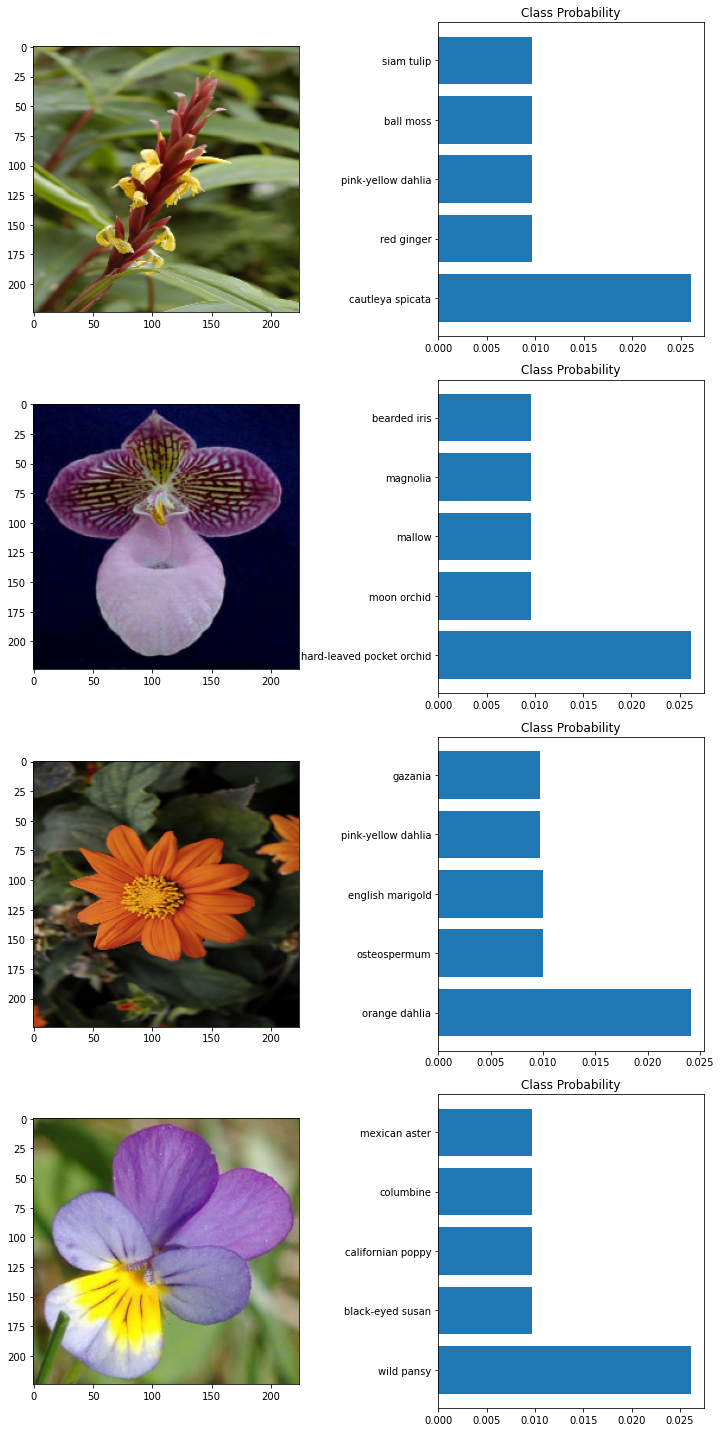

In [226]:
# TODO: Plot the input image along with the top 5 classes
img_paths = ['./test_images/cautleya_spicata.jpg','./test_images/hard-leaved_pocket_orchid.jpg','./test_images/orange_dahlia.jpg','./test_images/wild_pansy.jpg']
plt.figure(figsize=(10,20))
n=1
for img in img_paths:
    plt.subplot(4,2,n)
    n+=1
    probs, classes = predict(img,reloaded_keras_model, 5)
    im = Image.open(img)
    test_image = np.asarray(im)

    processed_test_image = process_image(test_image)
    plt.imshow(processed_test_image)

    plt.subplot(4,2,n)
    labels_strs = [new_class_names[int(idx)] for idx in classes]
    plt.barh(labels_strs, probs)
    plt.title('Class Probability')
    n+=1
plt.tight_layout()